<a href="https://colab.research.google.com/github/Jeonyujeong/RottenFruitsModel/blob/master/VGG16_rotten_cherry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 체리 데이터 가져오기

In [1]:
!wget https://github.com/RottenFruitsOSS/DataSet/raw/master/dataset.zip

--2020-08-15 04:06:59--  https://github.com/RottenFruitsOSS/DataSet/raw/master/dataset.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RottenFruitsOSS/DataSet/master/dataset.zip [following]
--2020-08-15 04:07:00--  https://raw.githubusercontent.com/RottenFruitsOSS/DataSet/master/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12194858 (12M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  11.63M  22.2MB/s    in 0.5s    

2020-08-15 04:07:01 (22.2 MB/s) - ‘dataset.zip’ saved [12194858/12194858]



In [ ]:
!unzip dataset.zip

In [8]:
%%shell

mkdir dataset
mv test dataset/
mv train dataset/

# 설정 값 정의

In [53]:
# import the necessary packages
import os

# initialize the path to the input directory containing our dataset
# of images
DATASET_PATH = "dataset"

# initialize the class labels in the dataset
CLASSES = ["advanced", "damage", "early", "normal"]

# define the size of the training, validation (which comes from the
# train split), and testing splits, respectively
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.1
TEST_SPLIT = 0.25

# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-6
MAX_LR = 1e-3
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "rotten_cherry.model"])

# define the path to the output learning rate finder plot, training
# history plot and cyclical learning rate plot
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])

# 모듈 임포팅

In [37]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")


In [38]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

# 데이터 로딩과 준비
## 파일 로딩 함수

In [39]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory and initialize
    # our lists of images and class labels
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    labels = []

    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label
        label = imagePath.split(os.path.sep)[-2]

        # load the image, convert it to RGB channel ordering, and resize
        # it to be a fixed 224x224 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        # update the data and labels lists, respectively

        data.append(image)
        labels.append(label)

    # convert the data and labels to NumPy arrays
    return np.array(data, dtype="float32"), np.array(labels)

## 영상 데이터 파일 로딩

In [40]:
print("[INFO] processing data...")
data, labels_ = load_dataset(DATASET_PATH)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels_)

[INFO] processing data...


In [41]:
print(data.shape)
print(labels_)
print(labels)

(2605, 224, 224, 3)
['advanced' 'advanced' 'advanced' ... 'damage' 'damage' 'damage']
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]


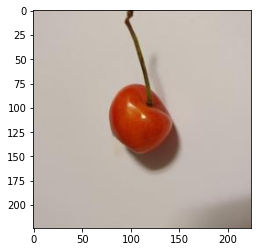

In [42]:
plt.imshow(data[0]/255)
plt.show()

## 데이터 쪼개기 및 데이터 증강

In [43]:
# TRAIN_SPLIT = 0.75
# VAL_SPLIT = 0.1
# TEST_SPLIT = 0.25

# partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=TEST_SPLIT, random_state=42)

# take the validation split from the training split
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,
	test_size=VAL_SPLIT, random_state=84)

# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# 모델 정의

- VGGNet은 옥스포드 대학의 연구팀 VGG에 의해 개발된 모델이다. 

- VGGNet은 16개 또는 19개의 층으로 구성된 모델을 의미한다. (VGG16, VGG19)

![VGG16 구조](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FK990l%2FbtqwDJ7C54R%2F664Ksm6gyTGBR1wK3YPDFk%2Fimg.png)




In [44]:
# ImageNet 데이터 셋에서 사전 학습된 VGG16 모델 조정함.

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False
	
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [45]:
# !cat /content/natural-disaster-detection/pyimagesearch/learningratefinder.py

In [46]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta

		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []

		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]

		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)

		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)

		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss

		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return

		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth

		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()

		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)

		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)

		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))

		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

		# compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch

		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)

		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)

		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))

		# check to see if we are using a data iterator
		if useGen:
			self.model.fit_generator(
				trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])

		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				trainData[0], trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)

		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]

		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")

		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)

In [47]:
!mkdir /content/output

mkdir: cannot create directory ‘/content/output’: File exists


[INFO] finding learning rate...
Epoch 1/20
55/55 [==============================] - 20s 355ms/step - loss: 10.7861 - accuracy: 0.3682
Epoch 2/20
55/55 [==============================] - 19s 350ms/step - loss: 10.8252 - accuracy: 0.3580
Epoch 3/20
55/55 [==============================] - 19s 351ms/step - loss: 10.8503 - accuracy: 0.3529
Epoch 4/20
55/55 [==============================] - 19s 350ms/step - loss: 10.8216 - accuracy: 0.3643
Epoch 5/20
55/55 [==============================] - 19s 354ms/step - loss: 10.6740 - accuracy: 0.3665
Epoch 6/20
55/55 [==============================] - 19s 353ms/step - loss: 11.0079 - accuracy: 0.3654
Epoch 7/20
55/55 [==============================] - 20s 355ms/step - loss: 9.8110 - accuracy: 0.4030
Epoch 8/20
55/55 [==============================] - 20s 356ms/step - loss: 9.2230 - accuracy: 0.4234
Epoch 9/20
55/55 [==============================] - 20s 355ms/step - loss: 7.5403 - accuracy: 0.4604
Epoch 10/20
55/55 [==============================] - 

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


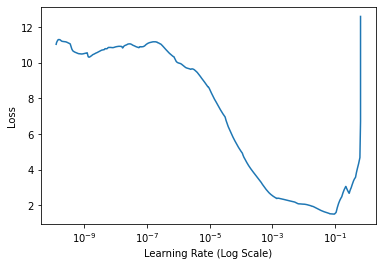

In [48]:
args = {"lr_find": 1}

# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
if args["lr_find"] > 0:
	
	# initialize the learning rate finder and then train with learning
	# rates ranging from 1e-10 to 1e+1
	print("[INFO] finding learning rate...")
	lrf = LearningRateFinder(model)
	lrf.find(
		aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((trainX.shape[0] / float(BATCH_SIZE))),
		epochs=20,
		batchSize=BATCH_SIZE)
 
	# plot the loss for the various learning rates and save the
	# resulting plot to disk
	lrf.plot_loss()
	plt.savefig(LRFIND_PLOT_PATH)
 
	# gracefully exit the script so we can adjust our learning rates
	# in the config and then train the network for our full set of
	# epochs
	print("[INFO] learning rate finder complete")
	print("[INFO] examine plot and adjust learning rates before training")
	sys.exit(0)

![Learning Rate](https://pyimagesearch.com/wp-content/uploads/2019/11/keras_natural_disaster_lrfind_plot.png)

In [ ]:
# !cat /content/natural-disaster-detection/pyimagesearch/clr_callback.py

In [50]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np


class CyclicLR(Callback):
	"""This callback implements a cyclical learning rate policy (CLR).
	The method cycles the learning rate between two boundaries with
	some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
	The amplitude of the cycle can be scaled on a per-iteration or
	per-cycle basis.
	This class has three built-in policies, as put forth in the paper.
	"triangular":
		A basic triangular cycle w/ no amplitude scaling.
	"triangular2":
		A basic triangular cycle that scales initial amplitude by half each cycle.
	"exp_range":
		A cycle that scales initial amplitude by gamma**(cycle iterations) at each
		cycle iteration.
	For more detail, please see paper.

	# Example
		```python
			clr = CyclicLR(base_lr=0.001, max_lr=0.006,
								step_size=2000., mode='triangular')
			model.fit(X_train, Y_train, callbacks=[clr])
		```

	Class also supports custom scaling functions:
		```python
			clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
			clr = CyclicLR(base_lr=0.001, max_lr=0.006,
								step_size=2000., scale_fn=clr_fn,
								scale_mode='cycle')
			model.fit(X_train, Y_train, callbacks=[clr])
		```
	# Arguments
		base_lr: initial learning rate which is the
			lower boundary in the cycle.
		max_lr: upper boundary in the cycle. Functionally,
			it defines the cycle amplitude (max_lr - base_lr).
			The lr at any cycle is the sum of base_lr
			and some scaling of the amplitude; therefore
			max_lr may not actually be reached depending on
			scaling function.
		step_size: number of training iterations per
			half cycle. Authors suggest setting step_size
			2-8 x training iterations in epoch.
		mode: one of {triangular, triangular2, exp_range}.
			Default 'triangular'.
			Values correspond to policies detailed above.
			If scale_fn is not None, this argument is ignored.
		gamma: constant in 'exp_range' scaling function:
			gamma**(cycle iterations)
		scale_fn: Custom scaling policy defined by a single
			argument lambda function, where
			0 <= scale_fn(x) <= 1 for all x >= 0.
			mode paramater is ignored
		scale_mode: {'cycle', 'iterations'}.
			Defines whether scale_fn is evaluated on
			cycle number or cycle iterations (training
			iterations since start of cycle). Default is 'cycle'.
	"""

	def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
				 gamma=1., scale_fn=None, scale_mode='cycle'):
		super(CyclicLR, self).__init__()

		self.base_lr = base_lr
		self.max_lr = max_lr
		self.step_size = step_size
		self.mode = mode
		self.gamma = gamma
		if scale_fn == None:
			if self.mode == 'triangular':
				self.scale_fn = lambda x: 1.
				self.scale_mode = 'cycle'
			elif self.mode == 'triangular2':
				self.scale_fn = lambda x: 1 / (2. ** (x - 1))
				self.scale_mode = 'cycle'
			elif self.mode == 'exp_range':
				self.scale_fn = lambda x: gamma ** (x)
				self.scale_mode = 'iterations'
		else:
			self.scale_fn = scale_fn
			self.scale_mode = scale_mode
		self.clr_iterations = 0.
		self.trn_iterations = 0.
		self.history = {}

		self._reset()

	def _reset(self, new_base_lr=None, new_max_lr=None,
			   new_step_size=None):
		"""Resets cycle iterations.
		Optional boundary/step size adjustment.
		"""
		if new_base_lr != None:
			self.base_lr = new_base_lr
		if new_max_lr != None:
			self.max_lr = new_max_lr
		if new_step_size != None:
			self.step_size = new_step_size
		self.clr_iterations = 0.

	def clr(self):
		cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
		x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
		if self.scale_mode == 'cycle':
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
		else:
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
				self.clr_iterations)

	def on_train_begin(self, logs={}):
		logs = logs or {}

		if self.clr_iterations == 0:
			K.set_value(self.model.optimizer.lr, self.base_lr)
		else:
			K.set_value(self.model.optimizer.lr, self.clr())

	def on_batch_end(self, epoch, logs=None):

		logs = logs or {}
		self.trn_iterations += 1
		self.clr_iterations += 1

		self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
		self.history.setdefault('iterations', []).append(self.trn_iterations)

		for k, v in logs.items():
			self.history.setdefault(k, []).append(v)

		K.set_value(self.model.optimizer.lr, self.clr())

In [54]:
# otherwise, we have already defined a learning rate space to train
# over, so compute the step size and initialize the cyclic learning
# rate method
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
	mode=CLR_METHOD,
	base_lr=MIN_LR,
	max_lr=MAX_LR,
	step_size=stepSize)

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
	validation_data=(valX, valY),
	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
	epochs=NUM_EPOCHS,
	callbacks=[clr],
	verbose=1)

[INFO] training network...
Epoch 1/48
54/54 [==============================] - 20s 379ms/step - loss: 1.0953 - accuracy: 0.5629 - val_loss: 1.1078 - val_accuracy: 0.5510
Epoch 2/48
54/54 [==============================] - 20s 376ms/step - loss: 1.0919 - accuracy: 0.5664 - val_loss: 1.1078 - val_accuracy: 0.5510
Epoch 3/48
54/54 [==============================] - 20s 377ms/step - loss: 1.1765 - accuracy: 0.5642 - val_loss: 1.1078 - val_accuracy: 0.5510
Epoch 4/48
54/54 [==============================] - 20s 379ms/step - loss: 1.0951 - accuracy: 0.5629 - val_loss: 1.1078 - val_accuracy: 0.5510
Epoch 5/48
54/54 [==============================] - 20s 376ms/step - loss: 1.0965 - accuracy: 0.5629 - val_loss: 1.1078 - val_accuracy: 0.5510
Epoch 6/48
54/54 [==============================] - 20s 376ms/step - loss: 1.0967 - accuracy: 0.5617 - val_loss: 1.1078 - val_accuracy: 0.5510
Epoch 7/48
54/54 [==============================] - 20s 375ms/step - loss: 1.0948 - accuracy: 0.5652 - val_loss: 1.

In [55]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=CLASSES))

# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)

[INFO] evaluating network...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    advanced       0.00      0.00      0.00       170
      damage       0.00      0.00      0.00        60
       early       0.56      1.00      0.72       366
      normal       0.00      0.00      0.00        56

    accuracy                           0.56       652
   macro avg       0.14      0.25      0.18       652
weighted avg       0.32      0.56      0.40       652

[INFO] serializing network to 'output/rotten_cherry.model'...
INFO:tensorflow:Assets written to: output/rotten_cherry.model/assets


# 히스토리 확인

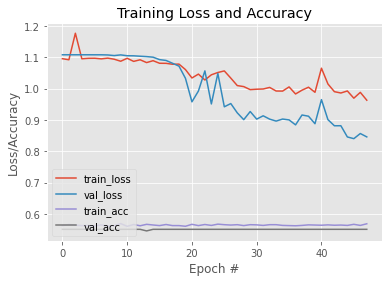

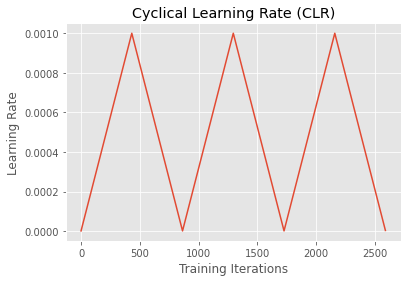

In [56]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)

# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(CLR_PLOT_PATH)

# 이미지 예측

In [57]:
from tensorflow.keras.models import load_model
from imutils import paths
from IPython.display import Image
import numpy as np
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from IPython.display import Image, display
from google.colab.patches import cv2_imshow

In [58]:
!mkdir output/images

In [66]:
MODEL_PATH = "/content/output/rotten_cherry.model"
SAMPLE_SIZE = 5
OUTPUT_IMAGE_PATH = "output/images"

[INFO] loading model...
[INFO] predicting...
['dataset/train/normal/normal_30.jpg', 'dataset/train/normal/normal_51.jpg', 'dataset/test/advanced/advanced_345.jpg', 'dataset/train/early/early_103.jpg', 'dataset/train/damage/damage_184.jpg']
output/images


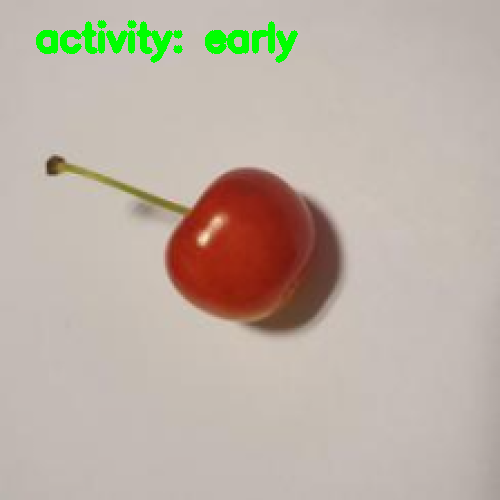

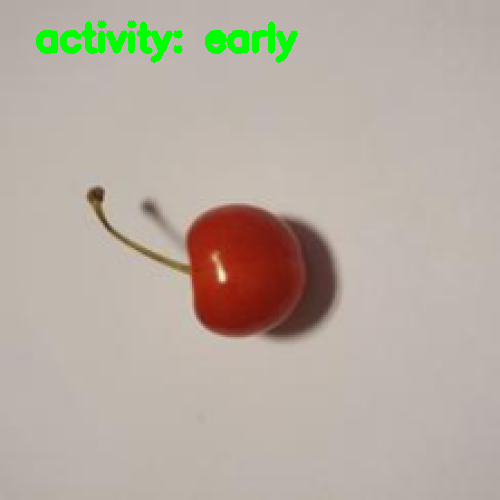

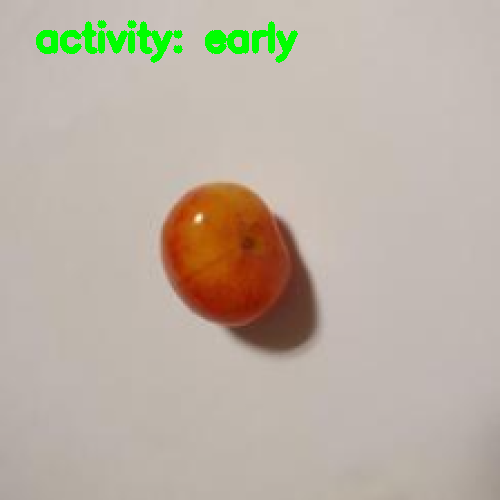

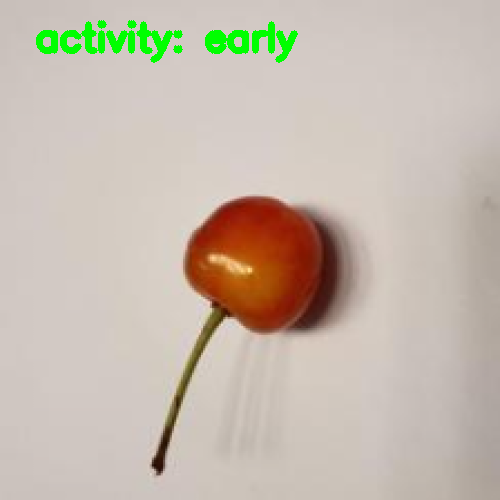

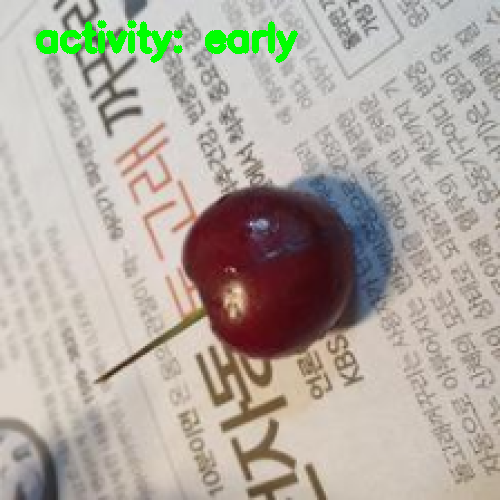

In [72]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(MODEL_PATH)

# grab the paths to the disaster images, respectively
print("[INFO] predicting...")
imagePaths = list(paths.list_images(DATASET_PATH))

# combine the two image path lists, randomly shuffle them, and sample
# them
random.shuffle(imagePaths)
imagePaths = imagePaths[:SAMPLE_SIZE]
print(imagePaths)
print(OUTPUT_IMAGE_PATH)

# loop over the sampled image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the image and clone it
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    output = image.copy()
 
	# resize the input image to be a fixed 128x128 pixels, ignoring
	# aspect ratio
    image = cv2.resize(image, (244, 244))
    image = image.astype("float32") / 255.0
		
	# make predictions on the image
    preds = model.predict(np.expand_dims(image, axis=0))[0]
    j = np.argmax(preds)
    label = CLASSES[j]

	# draw the activity on the output frame
    text = "activity: {}".format(label)
    output = imutils.resize(output, width=500)
    cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

	# write the output image to disk	 
    filename = "{}.png".format(i)
    p = os.path.sep.join([OUTPUT_IMAGE_PATH, filename])
    cv2_imshow(output)
    cv2.imwrite(p, output)

In [71]:
!rm -r output/images/
!mkdir output/images/

In [73]:
!zip -r output.zip ./output/*

updating: output/clr_plot.png (deflated 4%)
updating: output/images/ (stored 0%)
updating: output/images/0.png (deflated 14%)
updating: output/images/3.png (deflated 13%)
updating: output/images/4.png (deflated 7%)
updating: output/images/1.png (deflated 12%)
updating: output/images/2.png (deflated 14%)
updating: output/lrfind_plot.png (deflated 5%)
updating: output/rotten_cherry.model/ (stored 0%)
updating: output/rotten_cherry.model/variables/ (stored 0%)
updating: output/rotten_cherry.model/variables/variables.data-00000-of-00001 (deflated 34%)
updating: output/rotten_cherry.model/variables/variables.index (deflated 67%)
updating: output/rotten_cherry.model/saved_model.pb (deflated 91%)
updating: output/rotten_cherry.model/assets/ (stored 0%)
updating: output/training_plot.png (deflated 4%)


In [74]:
from google.colab import files
files.download("output.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 모델 로드

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
import argparse
import cv2

In [ ]:
# load the trained model from disk
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)

[INFO] loading model and label binarizer...
